In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import output
!cp "/content/drive/MyDrive/YBIGTA/DACON/2차 배포.zip" "2차 배포.zip"
!unzip "2차 배포.zip"

Archive:  2차 배포.zip
  inflating: dirty_mnist_2nd.zip     
  inflating: dirty_mnist_2nd_answer.csv  
  inflating: mnist_data.zip          
  inflating: sample_submission.csv   
  inflating: test_dirty_mnist_2nd.zip  


In [ ]:
from google.colab import output
!mkdir "./dirty_mnist"
!unzip "dirty_mnist_2nd.zip" -d "./dirty_mnist/"
!mkdir "./test_dirty_mnist"
!unzip "test_dirty_mnist_2nd.zip" -d "./test_dirty_mnist/"
output.clear()

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=56f9fd56bf8dd06ed6f36f329d7cc3d25c2938dacbfb710be623fe8884362fa0
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
!pip install git+https://github.com/cmpark0126/pytorch-polynomial-lr-decay.git

  Cloning https://github.com/cmpark0126/pytorch-polynomial-lr-decay.git to /tmp/pip-req-build-w53ny350
  Running command git clone -q https://github.com/cmpark0126/pytorch-polynomial-lr-decay.git /tmp/pip-req-build-w53ny350
  Created wheel for torch-poly-lr-decay: filename=torch_poly_lr_decay-0.0.1-cp36-none-any.whl size=3832 sha256=89b885abeab02d3a1e058866b1f23f9ec2cc13592f922c0139bd843bad7b7809
  Stored in directory: /tmp/pip-ephem-wheel-cache-07zgyo9o/wheels/5a/b7/09/d748b20c9bdfc768a33c37a28b2ad7dd9ec3e79e5152cb1618
Successfully built torch-poly-lr-decay


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from efficientnet_pytorch import EfficientNet
from torch_poly_lr_decay import PolynomialLRDecay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 디바이스 설정

In [ ]:
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self,
                 dir_path,
                 meta_df,
                 transforms=None,
                 augmentations=None):
        
        self.dir_path = dir_path # 데이터의 이미지가 저장된 디렉터리 경로
        self.meta_df = meta_df # 데이터의 인덱스와 정답지가 들어있는 DataFrame

        self.transforms = transforms
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.meta_df)
    
    def __getitem__(self, index):
        # 폴더 경로 + 이미지 이름 + .png => 파일의 경로
        # 참고) "12".zfill(5) => 00012
        #       "146".zfill(5) => 00145
        image = cv2.imread(self.dir_path +\
                           str(self.meta_df.iloc[index,0]).zfill(5) + '.png')

        # transform 적용
        if self.transforms:
            image = self.transforms(image)

        # 정답 numpy array생성
        label = self.meta_df.iloc[index, 1:].values.astype('float')
        label = torch.FloatTensor(label)

        sample = {'image': image, 'label': label}

        return sample

In [ ]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [ ]:
dirty_mnist_answer = pd.read_csv("dirty_mnist_2nd_answer.csv")
# dirty_mnist라는 디렉터리 속에 들어있는 파일들의 이름을 namelist라는 변수에 저장
namelist = os.listdir('./dirty_mnist/')

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [ ]:
class EfficientNet_MultiLabel(nn.Module):
    def __init__(self, in_channels):
        super(EfficientNet_MultiLabel, self).__init__()
        self.network = EfficientNet.from_pretrained('efficientnet-b4', in_channels=in_channels)
        self.output_layer = nn.Linear(1000, 26)

    def forward(self, x):
        x = F.relu(self.network(x))
        x = torch.sigmoid(self.output_layer(x))
        return x

In [ ]:
# cross validation을 적용하기 위해 KFold 생성
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 10
batch_size = 32

In [ ]:
# dirty_mnist_answer에서 train_idx와 val_idx를 생성
best_models = [] # 폴드별로 가장 validation acc가 높은 모델 저장

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1): # fold_index 1부터 시작
    # 하나의 fold만 실행
    if fold_index == 2:
      break

    print(f'[fold: {fold_index}]')
    # cuda cache 초기화
    torch.cuda.empty_cache()

    # train fold, validation fold 분할
    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer  = dirty_mnist_answer.iloc[val_idx]

    # Dataset 정의
    train_dataset = DatasetMNIST("dirty_mnist/", train_answer, transforms_train)
    valid_dataset = DatasetMNIST("dirty_mnist/", test_answer, transforms_test)

    # DataLoader 정의
    train_data_loader = DataLoader(
        train_dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 3
    )
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 3
    )

    # 모델 선언
    # gpu에 모델 할당
    model = EfficientNet_MultiLabel(in_channels=3).to(device)

    # 훈련 옵션 설정
    base_optimizer = torch.optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, lr=0.001, momentum=0.9)
    
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size = 5,
                                                gamma = 0.75)
    criterion = torch.nn.BCELoss()

    # 훈련 시작
    valid_acc_max = 0
    for epoch in range(epochs):
        train_acc_list = []
        with tqdm(train_data_loader, # train_data_loader를 iterative하게 반환
                total=train_data_loader.__len__(), # train_data_loader의 크기
                unit="batch") as train_bar: # 한번 반환하는 sample의 단위는 "batch"
            for sample in train_bar:
                train_bar.set_description(f"Train Epoch {epoch}")
                # 갱신할 변수들에 대한 모든 변화도를 0으로 초기화
                optimizer.zero_grad()

                images, labels = sample['image'], sample['label']
                # tensor를 gpu에 올리기 
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 train 모드로 설정
                model.train()
                # .forward()에서 중간 노드의 gradient를 계산
                with torch.set_grad_enabled(True):
                    # 모델 예측
                    probs  = model(images)
                    # loss 계산
                    loss = criterion(probs, labels)
                    # 중간 노드의 gradient로 backpropagation을 적용하여 gradient 계산
                    loss.backward()

                    # sam optimizer first_steop
                    optimizer.first_step(zero_grad=True)
                    
                    # sam optimizer second_steop
                    criterion(model(images), labels).backward()
                    optimizer.second_step(zero_grad=True)

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)

                # 현재 progress bar에 현재 미니배치의 loss 결과 출력
                train_bar.set_postfix(train_loss= loss.item(),
                                      train_acc = train_acc)
                

        # 1개 epoch학습 후 Validation 점수 계산
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit="batch") as valid_bar:
            for sample in valid_bar:
                valid_bar.set_description(f"Valid Epoch {epoch}")
                optimizer.zero_grad()

                images, labels = sample['image'], sample['label']
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 eval모드로 설정
                model.eval()
                # .forward()에서 중간 노드의 gradient를 계산
                with torch.no_grad():
                    # validation loss만을 계산
                    probs  = model(images)
                    valid_loss = criterion(probs, labels)

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss = valid_loss.item(),
                                      valid_acc = valid_acc)

        # 모델 저장
        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            MODEL = "efficientnet-b4"
            path = "/content/drive/MyDrive/YBIGTA/DACON/"
            torch.save(best_model, f'{path}{fold_index}_{MODEL}_{valid_loss.item():2.4f}_epoch_{epoch}.pth')

    # 폴드별로 가장 좋은 모델 저장
    best_models.append(best_model)

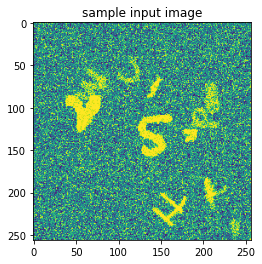

예측값 :  Index(['v'], dtype='object')
정답값 :  Index(['a', 'c', 'd', 'f', 'i', 'l', 'm', 'n', 'o', 'r', 's'], dtype='object')


In [ ]:
# 예측 테스트
# gpu에 올라가 있는 tensor -> cpu로 이동 -> numpy array로 변환
sample_images = images.cpu().detach().numpy()
sample_prob = probs
sample_labels = labels

idx = 1
plt.imshow(sample_images[idx][0])
plt.title("sample input image")
plt.show()

print('예측값 : ',dirty_mnist_answer.columns[1:][sample_prob[idx] > 0.5])
print('정답값 : ', dirty_mnist_answer.columns[1:][sample_labels[idx] > 0.5])

In [ ]:
#test Dataset 정의
sample_submission = pd.read_csv("sample_submission.csv")
test_dataset = DatasetMNIST("test_dirty_mnist/", sample_submission, transforms_test)
test_data_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 3
)

In [ ]:
predictions_list = []
# 배치 단위로 추론
prediction_df = pd.read_csv("sample_submission.csv")

# fold마다 가장 좋은 모델을 이용하여 예측
for model in best_models:
    # 0으로 채워진 array 생성
    prediction_array = np.zeros([prediction_df.shape[0],
                                 prediction_df.shape[1] -1])
    for idx, sample in enumerate(test_data_loader):
        with torch.no_grad():
            # 추론
            model.eval()
            images = sample['image']
            images = images.to(device)
            probs  = model(images)
            probs = probs.cpu().detach().numpy()
            preds = (probs > 0.5)

            # 예측 결과를 prediction_array에 입력
            batch_index = batch_size * idx
            prediction_array[batch_index: batch_index + images.shape[0],:]\
                         = preds.astype(int)
                         
    # 채널을 하나 추가하여 list에 append
    predictions_list.append(prediction_array[...,np.newaxis])

In [ ]:
# axis = 2를 기준으로 평균
predictions_array = np.concatenate(predictions_list, axis = 2)
predictions_mean = predictions_array.mean(axis = 2)

# 평균 값이 0.5보다 클 경우 1 작으면 0
predictions_mean = (predictions_mean > 0.5) * 1
predictions_mean

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.iloc[:, 1:] = predictions_mean
sample_submission.to_csv("efficientnet_b4.csv", index = False)
sample_submission

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,50000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,50001,0,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,1,0,0,1,1
2,50002,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
3,50003,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,1,1
4,50004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,54995,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4996,54996,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4997,54997,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4998,54998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
